## Regression Using NLP Text

##### This model will appear as 'DunnBC22/distilbert-base-uncased-Regression-Simpsons_Plus_Others' on my HuggingFace profile.

##### Data Sources:

*https://www.kaggle.com/datasets/mattbarty/the-simpsons-s1s32-imdb-scores-episode-info

*https://www.kaggle.com/datasets/maddyramsey/brookyln-nine-nine-imdb-ratings

*https://www.kaggle.com/datasets/hod101s/seinfeld-imdb-ratings

*https://www.kaggle.com/datasets/bcruise/big-bang-theory-episodes?select=big_bang_theory_imdb.csv

*https://www.kaggle.com/datasets/bcruise/30-rock-episode-data?select=30_rock_imdb.csv

*https://www.kaggle.com/datasets/imbenab/community-episodes-imdb-ratings

*https://www.kaggle.com/datasets/bcruise/parks-and-recreation-episode-data?select=parks_and_rec_imdb.csv

*https://www.kaggle.com/datasets/kapastor/the-office-imdb-ratings-per-episode

*https://www.kaggle.com/datasets/bcruise/how-i-met-your-mother-episodes-data?select=himym_imdb.csv

*https://www.kaggle.com/datasets/rprkh15/modern-family-dataset

*I pulled the episode descriptions manually for the following series from the respective page of each series on imdb.com: 

1) Two and a Half Men,
2) Young Sheldon, 
3) Married... With Children
4) Family Guy
5) South Park
6) That '70s Show
7) It's Always Sunny in Philadelphia

#### Import Necessary Libraries

In [1]:
import os, math, random, re, logging
os.environ['TOKENIZERS_PARALLELISM']='false'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, set_seed, get_scheduler

from datasets import Dataset, DatasetDict

NOTE: Redirects are currently not supported in Windows or MacOs.


### Exploratory Data Analysis (EDA)

#### The Simpsons Dataset

In [2]:
data_sim = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/imdb_simpsons_dataset.csv', engine="c")
data_sim.drop(columns=['episode_no_abs', 'episode_votes', 'episode_votes', 'season_no', 'episode_no', 'episode_airdate', 'episode_name'], inplace=True)

data_sim.rename(columns={'episode_score' : 'label', 
                     'episode_description' : 'text'}, 
            inplace=True)

data_sim

,label,text
0,8.2,Homer is forced to become a department store S...
1,7.7,Bart ends up at a school for gifted children a...
2,7.4,"After losing his job, Homer contemplates endin..."
3,7.7,After being embarrassed by the rest of the fam...
4,8.0,After being beaten up by Nelson Muntz one too ...
...,...,...
700,6.8,Mr. Burns joins the plant-based burger busines...
701,6.2,Lisa's imaginary friend is a depressed British...
702,7.2,Lisa makes a shocking college decision that hu...
703,6.5,A British secret agent comes to Springfield to...


#### Brooklyn Nine Nine Dataset

In [3]:
data_bnn = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/All_B99_eps.csv', engine="c")
data_bnn.drop(columns=['Season', 'Episode', 'Title', 'Airdate', 'Total Votes'], inplace=True)

data_bnn.rename(columns={'Rating' : 'label', 
                     'Episode Description' : 'text'}, 
            inplace=True)

data_bnn

,label,text
0,7.8,Detective Jake Peralta finds his work scrutini...
1,7.5,"When Jake arrives late for work, Captain Holt ..."
2,7.6,"With a backlog of unsolved cases, Jake finds h..."
3,7.7,"Jake meets an attractive Medical Examiner, but..."
4,8.0,A detective from Major Crimes takes over Jake'...
...,...,...
148,6.7,"When the FBI takes over a high-profile case, J..."
149,8.1,"Terry, Jake and Charles visit the Boyle Family..."
150,8.1,The squad comes together to work an important ...
151,9.4,The squad takes stock of their eight years tog...


#### Seinfeld Dataset

In [4]:
data_sein = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/All_B99_eps.csv', engine="c")
data_sein.drop(columns=['Season', 'Episode', 'Title', 'Airdate', 'Total Votes'], inplace=True)

data_sein.rename(columns={'Rating' : 'label', 'Episode Description' : 'text'}, inplace=True)

data_sein

,label,text
0,7.8,Detective Jake Peralta finds his work scrutini...
1,7.5,"When Jake arrives late for work, Captain Holt ..."
2,7.6,"With a backlog of unsolved cases, Jake finds h..."
3,7.7,"Jake meets an attractive Medical Examiner, but..."
4,8.0,A detective from Major Crimes takes over Jake'...
...,...,...
148,6.7,"When the FBI takes over a high-profile case, J..."
149,8.1,"Terry, Jake and Charles visit the Boyle Family..."
150,8.1,The squad comes together to work an important ...
151,9.4,The squad takes stock of their eight years tog...


#### The Big Bang Theory Dataset

In [5]:
data_tbbt = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/big_bang_theory_imdb.csv', engine="c")
data_tbbt.drop(columns=['season', 'episode_num', 'title', 'original_air_date', 'total_votes'], inplace=True)

data_tbbt.rename(columns={'imdb_rating' : 'label', 
                     'desc' : 'text'}, 
            inplace=True)

data_tbbt

,label,text
0,6.7,"The first Pilot of what will become ""The Big B..."
1,8.2,A pair of socially awkward theoretical physici...
2,8.3,Penny is furious with Leonard and Sheldon when...
3,7.7,Leonard gets upset when he discovers that Penn...
4,8.1,Sheldon's mother is called to intervene when h...
...,...,...
275,7.1,Koothrappali is worried people won't take him ...
276,7.2,Kripke has proof that Dr. Pemberton plagiarize...
277,7.9,Leonard is pleasantly surprised when Beverly c...
278,9.0,Sheldon and Amy await big news.


#### 30 Rock Dataset

In [6]:
data_30r = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/30_rock_imdb.csv', engine="c")
data_30r.drop(columns=['season', 'episode_num', 'title', 'original_air_date', 'total_votes'], inplace=True)

data_30r.rename(columns={'imdb_rating' : 'label', 
                     'desc' : 'text'}, 
            inplace=True)

data_30r

,label,text
0,7.3,Liz Lemon is called upstairs to meet the new n...
1,7.5,The crew of The Girlie Show is skeptical of ha...
2,7.9,Jack convinces Liz to go on a date with his fr...
3,7.5,Jack joins the writing staff during a meeting ...
4,8.1,"Jack wants to integrate product placement in ""..."
...,...,...
133,8.3,Jack launches a plot to take over as Kabletown...
134,7.9,"Jack and Liz go to Florida, where they find ou..."
135,8.3,"Liz's adoption request is finally approved, bu..."
136,9.0,Liz is dealing with being a stay-at-home mom w...


#### The Office Dataset

In [7]:
data_office = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/TheOfficeIMDBPerEpisode.csv', engine="c")
data_office.drop(columns=['Season', 'Num_Votes', 'AirDate', 'Title', 'DirectedBy', 'WrittenBy'], inplace=True)

data_office.rename(columns={'Rating' : 'label', 
                     'Description' : 'text'}, 
            inplace=True)

data_office

,label,text
0,7.5,The premiere episode introduces the boss and s...
1,8.3,Michael's off color remark puts a sensitivity ...
2,7.8,Michael leaves Dwight in charge of picking the...
3,8.1,"Just for a laugh, Jim agrees to an alliance wi..."
4,8.4,Michael and his staff challenge the warehouse ...
...,...,...
183,8.0,Dwight shoots Stanley with a bull tranquilizer...
184,8.0,The employees hold a paper airplane competitio...
185,9.0,Dwight becomes regional manager after Andy qui...
186,9.5,Dwight prepares for a marriage proposal and hi...


#### Parks and Rec Dataset

In [8]:
data_PnR = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/parks_and_rec_imdb.csv', engine="c")
data_PnR.drop(columns=['season', 'episode_num', 'title', 'original_air_date', 'total_votes'], inplace=True)

data_PnR.rename(columns={'imdb_rating' : 'label', 'desc' : 'text'}, inplace=True)

data_PnR

,label,text
0,7.0,"In an attempt to beautify her town, Leslie Kno..."
1,7.1,Leslie gets a town hall meeting to discuss her...
2,7.1,Leslie gets a newspaper reporter to do a story...
3,7.3,Leslie tries to infiltrate the boys' club of p...
4,7.2,"At a banquet honouring her mother, Leslie trie..."
...,...,...
119,8.1,"During a business trip to Washington, April te..."
120,8.4,A traditional pie-baking competition causes pr...
121,8.5,The last episode of Andy's TV show brings his ...
122,8.6,Ben has to appoint a new mayor after mayor Gun...


#### How I Met Your Mother Dataset

In [9]:
data_himym = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/himym_imdb.csv', engine="c")
data_himym.drop(columns=['season', 'episode_num', 'title', 'original_air_date', 'total_votes'], inplace=True)

data_himym.rename(columns={'imdb_rating' : 'label', 
                     'desc' : 'text'}, 
            inplace=True)

data_himym

,label,text
0,8.5,It's the year 2030 and an older Ted Mosby is t...
1,8.2,Ted throws a party in hopes of seeing Robin ag...
2,8.1,Barney's plan to meet girls at the airport bac...
3,8.0,Ted reconnects with an old flame and soon reme...
4,8.3,"Robin, Ted, and Barney go to a hot new club, l..."
...,...,...
203,8.5,The guys try to figure out where Lily went aft...
204,8.3,Ted wants to get a wedding guest he especially...
205,8.9,"With only half an hour to go, both Barney and ..."
206,6.7,"After Barney and Robin's wedding, Ted builds u..."


#### Community Dataset

In [10]:
data_comm = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/Community_Episodes_IMDb_Ratings.csv', engine="c")
data_comm.drop(columns=['season', 'episode_number', 'title', 'airdate', 'total_votes'], inplace=True)

data_comm.rename(columns={'rating' : 'label', 
                     'desc' : 'text'}, 
            inplace=True)

data_comm

,label,text
0,7.8,An ex-lawyer is forced to return to community ...
1,7.9,Jeff takes steps to ensure that Brita will be ...
2,8.3,Brita comes between Abed and his father when s...
3,8.2,Jeff and Shirley bond by making fun of Britta'...
4,7.9,Señor Chang is on the hunt for a cheater and t...
...,...,...
105,7.8,"When a clever clever con man, Professor DeSalv..."
106,7.6,While on a road trip to get rid of a Greendale...
107,9.0,When a secret game of paintball occurs on camp...
108,8.6,A marriage proposal in Jeff's law class expose...


#### Modern Family

In [11]:
data_mod_fam = pd.read_csv('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/modern_family_info.csv', engine="c")
data_mod_fam.drop(columns=['Season-Episode', 'Title', 'Airdate', 'Total Votes', 'Image Link'], inplace=True)

data_mod_fam.rename(columns={'Rating' : 'label', 
                     'Description' : 'text'}, 
            inplace=True)

data_mod_fam

,label,text
0,8.2,"Jay must adapt to his young new wife, Gloria a..."
1,8.1,"After buying a new bike for his son, Phil ends..."
2,8.0,Jay takes Phil on a model-airplane excursion w...
3,8.2,Jay's ex-wife shows up for the first time foll...
4,8.3,A conflict between Manny and Luke spreads to t...
...,...,...
245,7.6,Phil and Claire take Haley and Dylan to dinner...
246,7.2,Claire lands an interview for her dream job bu...
247,7.3,Mitchell is having a hard time letting go of h...
248,8.3,Mitchell and Cam settle into their new normal;...


#### Many Other Datasets to Append to the Main Dataset

In [12]:
# Add the newer files to the dataset, including: 'Two & a Half Men', 'Young Sheldon', & 'It's Always Sunny in Philadelphia'

newer_data = pd.DataFrame()

for x in range(0,3):
    temp_df = pd.read_excel('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/tv_show_reviews.xlsx', sheet_name=x, names=['rating', 'title', 'review'])
    newer_data = pd.concat([temp_df, newer_data])

for x in range(0,2):
    temp_df = pd.read_excel('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/show_descriptions_ratings.xlsx', sheet_name=x, names=['rating', 'title', 'review'])
    newer_data = pd.concat([temp_df, newer_data])

for x in range(0,2):
    temp_df = pd.read_excel('~/Documents/nlpnn/Datasets/The Simpsons Info For Regression/tv_shows_2.xlsx', sheet_name=x, names=['rating', 'title', 'review'])
    newer_data = pd.concat([temp_df, newer_data])

newer_data['text'] = newer_data['title'].astype(str) + ' : ' + newer_data['review']

newer_data.drop(columns=['title', 'review'], inplace=True)
newer_data.rename(columns={'rating' : 'label'}, inplace=True)

newer_data = newer_data[~newer_data['label'].str.contains("[a-zA-Z]").fillna(False)]

newer_data['label'] = newer_data['label'].astype(float)

newer_data.info()
newer_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 1 to 261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   1699 non-null   float64
 1   text    1699 non-null   object 
dtypes: float64(1), object(1)
memory usage: 39.8+ KB


,label,text
1,7.7,Death Has a Shaddow : After drinking too much ...
2,7.5,I Never Met the Dead Man : Peter goes into sho...
3,7.6,Chitty Chitty Death Bang : Peter tries to make...
4,7.4,"Mind Over Murder : Under house arrest, Peter t..."
5,7.4,A Hero Sits Next Door : Peter becomes very jea...


#### Merge All Datasets

In [13]:
df_to_concat = [data_sim, data_bnn, data_sein, data_tbbt, data_30r, data_office, data_PnR, data_himym, data_comm, data_mod_fam, newer_data]

data = pd.concat(df_to_concat)
data

,label,text
0,8.2,Homer is forced to become a department store S...
1,7.7,Bart ends up at a school for gifted children a...
2,7.4,"After losing his job, Homer contemplates endin..."
3,7.7,After being embarrassed by the rest of the fam...
4,8.0,After being beaten up by Nelson Muntz one too ...
...,...,...
257,5.6,For Whom the Booty Calls : When Walden joins a...
258,5.9,A Beer-Battered Rip-Off : Walden worries that ...
259,5.7,Boompa Loved His Hookers : Walden discovers th...
260,5.7,Don't Give a Monkey a Gun : When their divorce...


#### Visualize Distribution of Scores

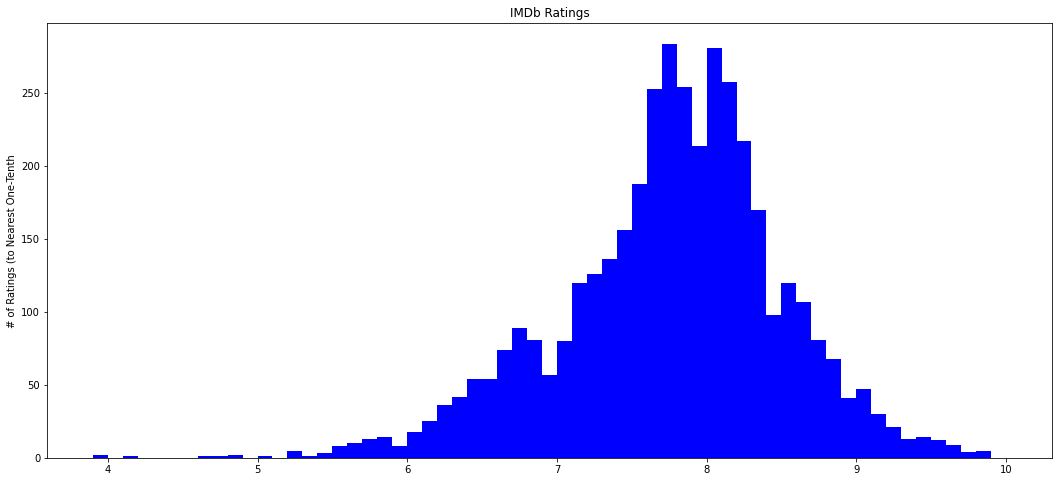

In [14]:
data['IMDb Ratings'] = data["label"]
data.hist("IMDb Ratings", color="Blue", grid=False, bins=61, range=(3.9,10), figsize=(18,8))
plt.suptitle('')
plt.xlabel('')
plt.ylabel('# of Ratings (to Nearest One-Tenth')
plt.show()

#### Visualize Distribution of Message Length

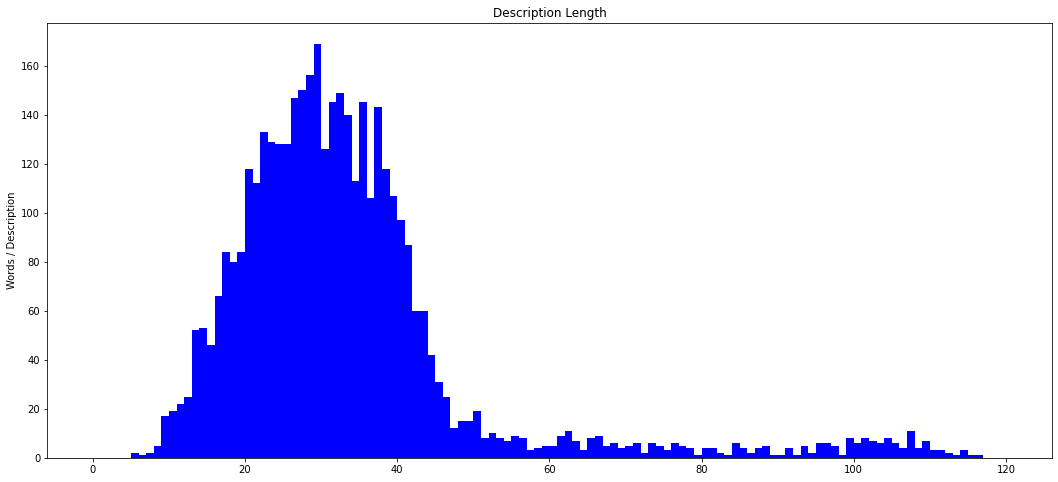

In [15]:
data['Description Length'] = data['text'].str.split().apply(len)

n=120
data.hist("Description Length", color="Blue", grid=False, bins=n, range=(0,n), figsize=(18,8))
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Words / Description')
plt.show()

#### Remove Unnecessary Features

In [16]:
data = data[data['Description Length'] < 120]

data = data.drop(columns=['Description Length', 'IMDb Ratings']).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   4008 non-null   float64
 1   text    4008 non-null   object 
dtypes: float64(1), object(1)
memory usage: 62.8+ KB


### Actual Project

#### Convert Pandas DataFrame to Datasets

In [17]:
dataset = Dataset.from_pandas(data)

#### Split into Train/Test/Validate Datasets & Combine into DatasetDict

In [18]:
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'eval' : test_valid['train']
})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (3206, 2)
Testing data shape: (401, 2)
Eval data shape: (401, 2)


#### Basic Values

In [19]:
num_of_epochs = 25
max_input_len = int(round(120*1.3, 0))
model_ckpt = "distilbert-base-uncased"
device = "cpu"
num_labels = 1
BATCH_SIZE=64
model_name = f"{model_ckpt}-Regression-Simpsons_Plus_Others"
learning_rate=2e-5
set_seed(42)

#### HuggingFace Access Token & Install git lfs 

In [20]:
# HuggingFace Access Token ... 

!git lfs install

Git LFS initialized.


#### Tokenize Whole Dataset

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=max_input_len, return_tensors="np")

encoded_ds = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Print Example to Ensure Edits Worked as Expected

In [22]:
print(encoded_ds['train'].features)
print(encoded_ds['train'])

{'label': Value(dtype='float64', id=None), 'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 3206
})


#### Initialize Model

In [23]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

#### Metrics Evaluation Function

In [24]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
        
    return {"mse": mse, "rmse": rmse, "mae": mae}

#### Trainer Arguments

In [25]:
training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=num_of_epochs, 
                                  per_device_train_batch_size=BATCH_SIZE, 
                                  per_device_eval_batch_size=BATCH_SIZE, 
                                  weight_decay=0.01,
                                  learning_rate=learning_rate,
                                  evaluation_strategy='epoch',
                                  save_total_limit=35,
                                  logging_strategy='epoch',
                                  load_best_model_at_end=True,
                                  metric_for_best_model='mae',
                                  greater_is_better=False,
                                  save_strategy='epoch',
                                  push_to_hub=True)

#### Build Trainer

In [26]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics_for_regression)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Simpsons_Plus_Others into local empty directory.


#### Train Trainer

In [27]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ch4/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3206
  Num Epochs = 25
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1275


  0%|          | 0/1275 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 29.5977, 'learning_rate': 1.9200000000000003e-05, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-51
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-51/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-51/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-51/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-51/special_tokens_map.json


{'eval_loss': 7.921452522277832, 'eval_mse': 7.92145299911499, 'eval_rmse': 2.814507484436035, 'eval_mae': 2.7032084465026855, 'eval_runtime': 123.0565, 'eval_samples_per_second': 3.259, 'eval_steps_per_second': 0.057, 'epoch': 1.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 4.4551, 'learning_rate': 1.8400000000000003e-05, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-102
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-102/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-102/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-102/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-102/special_tokens_map.json


{'eval_loss': 0.6727550625801086, 'eval_mse': 0.6727550625801086, 'eval_rmse': 0.8202164769172668, 'eval_mae': 0.6039096713066101, 'eval_runtime': 122.3561, 'eval_samples_per_second': 3.277, 'eval_steps_per_second': 0.057, 'epoch': 2.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 2.0068, 'learning_rate': 1.76e-05, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-153
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-153/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-153/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-153/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-153/special_tokens_map.json


{'eval_loss': 0.6033853888511658, 'eval_mse': 0.6033853888511658, 'eval_rmse': 0.7767788767814636, 'eval_mae': 0.5881670117378235, 'eval_runtime': 121.9023, 'eval_samples_per_second': 3.29, 'eval_steps_per_second': 0.057, 'epoch': 3.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.8734, 'learning_rate': 1.6800000000000002e-05, 'epoch': 4.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-204
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-204/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-204/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-204/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-204/special_tokens_map.json


{'eval_loss': 0.44231247901916504, 'eval_mse': 0.44231247901916504, 'eval_rmse': 0.6650657653808594, 'eval_mae': 0.49754762649536133, 'eval_runtime': 121.6687, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 4.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.7607, 'learning_rate': 1.6000000000000003e-05, 'epoch': 5.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-255
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-255/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-255/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-255/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-255/special_tokens_map.json


{'eval_loss': 0.3971346914768219, 'eval_mse': 0.3971346914768219, 'eval_rmse': 0.6301862597465515, 'eval_mae': 0.47251278162002563, 'eval_runtime': 121.6717, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 5.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.6901, 'learning_rate': 1.5200000000000002e-05, 'epoch': 6.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-306
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-306/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-306/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-306/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-306/special_tokens_map.json


{'eval_loss': 0.4004552364349365, 'eval_mse': 0.4004552364349365, 'eval_rmse': 0.6328153014183044, 'eval_mae': 0.47505298256874084, 'eval_runtime': 121.6576, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 6.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.6525, 'learning_rate': 1.4400000000000001e-05, 'epoch': 7.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-357
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-357/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-357/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-357/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-357/special_tokens_map.json


{'eval_loss': 0.40009310841560364, 'eval_mse': 0.40009304881095886, 'eval_rmse': 0.632529079914093, 'eval_mae': 0.4765656292438507, 'eval_runtime': 121.6724, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 7.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.6103, 'learning_rate': 1.3600000000000002e-05, 'epoch': 8.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-408
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-408/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-408/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-408/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-408/special_tokens_map.json


{'eval_loss': 0.42784202098846436, 'eval_mse': 0.42784199118614197, 'eval_rmse': 0.6540963053703308, 'eval_mae': 0.49535566568374634, 'eval_runtime': 121.6788, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 8.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.5659, 'learning_rate': 1.2800000000000001e-05, 'epoch': 9.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-459
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-459/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-459/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-459/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-459/special_tokens_map.json


{'eval_loss': 0.3902837634086609, 'eval_mse': 0.3902837932109833, 'eval_rmse': 0.6247269511222839, 'eval_mae': 0.4618476331233978, 'eval_runtime': 121.6765, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 9.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4968, 'learning_rate': 1.2e-05, 'epoch': 10.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-510
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-510/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-510/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-510/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-510/special_tokens_map.json


{'eval_loss': 0.39865919947624207, 'eval_mse': 0.39865919947624207, 'eval_rmse': 0.631394624710083, 'eval_mae': 0.4670499563217163, 'eval_runtime': 121.67, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 10.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4983, 'learning_rate': 1.1200000000000001e-05, 'epoch': 11.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-561
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-561/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-561/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-561/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-561/special_tokens_map.json


{'eval_loss': 0.47640976309776306, 'eval_mse': 0.47640982270240784, 'eval_rmse': 0.6902244687080383, 'eval_mae': 0.5324435830116272, 'eval_runtime': 121.6717, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 11.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4659, 'learning_rate': 1.04e-05, 'epoch': 12.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-612
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-612/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-612/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-612/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-612/special_tokens_map.json


{'eval_loss': 0.3913148045539856, 'eval_mse': 0.3913148045539856, 'eval_rmse': 0.6255515813827515, 'eval_mae': 0.461550235748291, 'eval_runtime': 121.6971, 'eval_samples_per_second': 3.295, 'eval_steps_per_second': 0.058, 'epoch': 12.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4532, 'learning_rate': 9.600000000000001e-06, 'epoch': 13.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-663
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-663/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-663/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-663/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-663/special_tokens_map.json


{'eval_loss': 0.451050341129303, 'eval_mse': 0.4510503113269806, 'eval_rmse': 0.6716027855873108, 'eval_mae': 0.5152690410614014, 'eval_runtime': 121.9371, 'eval_samples_per_second': 3.289, 'eval_steps_per_second': 0.057, 'epoch': 13.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4515, 'learning_rate': 8.8e-06, 'epoch': 14.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-714
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-714/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-714/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-714/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-714/special_tokens_map.json


{'eval_loss': 0.4009097218513489, 'eval_mse': 0.4009097218513489, 'eval_rmse': 0.6331743001937866, 'eval_mae': 0.4768402874469757, 'eval_runtime': 121.6684, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 14.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4506, 'learning_rate': 8.000000000000001e-06, 'epoch': 15.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-765
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-765/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-765/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-765/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-765/special_tokens_map.json


{'eval_loss': 0.45879897475242615, 'eval_mse': 0.4587990343570709, 'eval_rmse': 0.6773470640182495, 'eval_mae': 0.5160161256790161, 'eval_runtime': 121.8777, 'eval_samples_per_second': 3.29, 'eval_steps_per_second': 0.057, 'epoch': 15.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4249, 'learning_rate': 7.2000000000000005e-06, 'epoch': 16.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-816
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-816/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-816/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-816/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-816/special_tokens_map.json


{'eval_loss': 0.3940203785896301, 'eval_mse': 0.3940204381942749, 'eval_rmse': 0.6277104616165161, 'eval_mae': 0.4630068242549896, 'eval_runtime': 121.9292, 'eval_samples_per_second': 3.289, 'eval_steps_per_second': 0.057, 'epoch': 16.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4254, 'learning_rate': 6.4000000000000006e-06, 'epoch': 17.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-867
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-867/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-867/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-867/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-867/special_tokens_map.json


{'eval_loss': 0.4455680549144745, 'eval_mse': 0.4455680549144745, 'eval_rmse': 0.6675088405609131, 'eval_mae': 0.508367657661438, 'eval_runtime': 122.1603, 'eval_samples_per_second': 3.283, 'eval_steps_per_second': 0.057, 'epoch': 17.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4023, 'learning_rate': 5.600000000000001e-06, 'epoch': 18.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-918
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-918/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-918/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-918/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-918/special_tokens_map.json


{'eval_loss': 0.45170632004737854, 'eval_mse': 0.4517063498497009, 'eval_rmse': 0.672091007232666, 'eval_mae': 0.5095551013946533, 'eval_runtime': 122.2488, 'eval_samples_per_second': 3.28, 'eval_steps_per_second': 0.057, 'epoch': 18.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.3754, 'learning_rate': 4.800000000000001e-06, 'epoch': 19.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-969
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-969/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-969/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-969/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-969/special_tokens_map.json


{'eval_loss': 0.42104873061180115, 'eval_mse': 0.4210487902164459, 'eval_rmse': 0.6488827466964722, 'eval_mae': 0.48694470524787903, 'eval_runtime': 121.9381, 'eval_samples_per_second': 3.289, 'eval_steps_per_second': 0.057, 'epoch': 19.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.3865, 'learning_rate': 4.000000000000001e-06, 'epoch': 20.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1020
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1020/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1020/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1020/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1020/special_tokens_map.json


{'eval_loss': 0.4162963628768921, 'eval_mse': 0.4162963032722473, 'eval_rmse': 0.6452102661132812, 'eval_mae': 0.4829578697681427, 'eval_runtime': 121.6768, 'eval_samples_per_second': 3.296, 'eval_steps_per_second': 0.058, 'epoch': 20.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.3802, 'learning_rate': 3.2000000000000003e-06, 'epoch': 21.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1071
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1071/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1071/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1071/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1071/special_tokens_map.json


{'eval_loss': 0.4290342330932617, 'eval_mse': 0.4290342330932617, 'eval_rmse': 0.6550070643424988, 'eval_mae': 0.4904143512248993, 'eval_runtime': 121.9432, 'eval_samples_per_second': 3.288, 'eval_steps_per_second': 0.057, 'epoch': 21.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.4087, 'learning_rate': 2.4000000000000003e-06, 'epoch': 22.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1122
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1122/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1122/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1122/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1122/special_tokens_map.json


{'eval_loss': 0.40973570942878723, 'eval_mse': 0.40973570942878723, 'eval_rmse': 0.6401060223579407, 'eval_mae': 0.47446250915527344, 'eval_runtime': 121.9291, 'eval_samples_per_second': 3.289, 'eval_steps_per_second': 0.057, 'epoch': 22.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.3855, 'learning_rate': 1.6000000000000001e-06, 'epoch': 23.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1173
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1173/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1173/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1173/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1173/special_tokens_map.json


{'eval_loss': 0.44377976655960083, 'eval_mse': 0.44377973675727844, 'eval_rmse': 0.6661679744720459, 'eval_mae': 0.5027315020561218, 'eval_runtime': 121.6858, 'eval_samples_per_second': 3.295, 'eval_steps_per_second': 0.058, 'epoch': 23.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.3911, 'learning_rate': 8.000000000000001e-07, 'epoch': 24.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1224
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1224/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1224/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1224/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1224/special_tokens_map.json


{'eval_loss': 0.430152028799057, 'eval_mse': 0.430152028799057, 'eval_rmse': 0.6558597683906555, 'eval_mae': 0.490555077791214, 'eval_runtime': 121.6987, 'eval_samples_per_second': 3.295, 'eval_steps_per_second': 0.058, 'epoch': 24.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


{'loss': 1.3877, 'learning_rate': 0.0, 'epoch': 25.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1275
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1275/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1275/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1275/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-1275/special_tokens_map.json


{'eval_loss': 0.4286789298057556, 'eval_mse': 0.4286789298057556, 'eval_rmse': 0.6547357439994812, 'eval_mae': 0.4886947572231293, 'eval_runtime': 122.3846, 'eval_samples_per_second': 3.277, 'eval_steps_per_second': 0.057, 'epoch': 25.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-Regression-Simpsons_Plus_Others/checkpoint-612 (score: 0.461550235748291).


{'train_runtime': 83819.6528, 'train_samples_per_second': 0.956, 'train_steps_per_second': 0.015, 'train_loss': 2.759851989746094, 'epoch': 25.0}


TrainOutput(global_step=1275, training_loss=2.759851989746094, metrics={'train_runtime': 83819.6528, 'train_samples_per_second': 0.956, 'train_steps_per_second': 0.015, 'train_loss': 2.759851989746094, 'epoch': 25.0})

### Evaluate Model

#### Predictions

In [28]:
trainer.eval_dataset = encoded_ds['test']
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 401
  Batch size = 64


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3754067122936249,
 'eval_mse': 0.3754067122936249,
 'eval_rmse': 0.6127043962478638,
 'eval_mae': 0.4650583565235138,
 'eval_runtime': 127.2305,
 'eval_samples_per_second': 3.152,
 'eval_steps_per_second': 0.055,
 'epoch': 25.0}

#### Save Model & Push to Hub

In [29]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-uncased-Regression-Simpsons_Plus_Others
Configuration saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/config.json
Model weights saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Simpsons_Plus_Others/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/255M [00:00<?, ?B/s]

Upload file runs/Sep29_22-08-41_Brians-Mac-mini.local/events.out.tfevents.1664591273.Brians-Mac-mini.local.295…

Upload file runs/Sep29_22-08-41_Brians-Mac-mini.local/events.out.tfevents.1664507326.Brians-Mac-mini.local.295…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Simpsons_Plus_Others
   79d67f8..4b7986f  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Simpsons_Plus_Others
   4b7986f..d51f6b7  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Simpsons_Plus_Others/commit/4b7986fe915a58642ee6a2c42349bdec0d8a94f5'